# Results of SR-lite assessment with Alaska VHR
Paul Montesano Jan 2023  
__Manuscript:__ IGARSS submisttion on SR-lite workflow  

This assessment is based on performance summaries for a batch of data:  
`mmacande/srlite/performance_summaries.ipynb`

In [6]:
install.packages("tidyverse")

also installing the dependencies ‘DBI’, ‘glue’, ‘lifecycle’, ‘rlang’, ‘tidyselect’, ‘vctrs’, ‘withr’, ‘scales’, ‘gargle’, ‘googledrive’, ‘curl’, ‘timechange’, ‘vroom’, ‘conflicted’, ‘dbplyr’, ‘dplyr’, ‘dtplyr’, ‘forcats’, ‘ggplot2’, ‘googlesheets4’, ‘haven’, ‘httr’, ‘jsonlite’, ‘lubridate’, ‘magrittr’, ‘modelr’, ‘pillar’, ‘purrr’, ‘ragg’, ‘readr’, ‘readxl’, ‘reprex’, ‘rstudioapi’, ‘rvest’, ‘stringr’, ‘tibble’, ‘tidyr’


Warning message in install.packages("tidyverse"):
“installation of package ‘curl’ had non-zero exit status”
Warning message in install.packages("tidyverse"):
“installation of package ‘ragg’ had non-zero exit status”
Warning message in install.packages("tidyverse"):
“installation of package ‘purrr’ had non-zero exit status”
Warning message in install.packages("tidyverse"):
“installation of package ‘googledrive’ had non-zero exit status”
Warning message in install.packages("tidyverse"):
“installation of package ‘googlesheets4’ had non-zero exit status”
Warning message in 

In [1]:
# kernel : ILAB Kernel (R)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# kernel : ILAB Kernel (R)
#source('/home/pmontesa/code/3dsi/plot_functions.R')
source('/home/pmontesa/code/geoscitools/lm_functions.R')

In [3]:
# kernel : ILAB Kernel (R)
library(stringr)
library(fs)
library(glue)
library(viridis)
library(patchwork)

Loading required package: viridisLite



In [ ]:
# Kernel: r-environment-pmm
install.packages("sf")

In [5]:
library(sf)

Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE



In [ ]:
install.packages("remotes")
library(remotes)
remotes::install_github('https://github.com/ropensci/rnaturalearthhires')

In [6]:
# Kernel: r-environment-pmm
library(rnaturalearthhires)
library(rnaturalearth)

ERROR: Error in library(rnaturalearthhires): there is no package called ‘rnaturalearthhires’


In [3]:
# Kernel: r-environment-pmm
library(reshape2)
library(scales)
library(png)
library(plyr)

# Read global metrics (by image, band)

In [3]:
DIR_SRLITE = '/explore/nobackup/people/pmontesa/srlite'
#DIR_SRLITE_OUTPLOTS = '/explore/nobackup/people/pmontesa/userfs02/projects/srlite/plots'
DIR_SRLITE_OUTPLOTS = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss/plots/'

In [75]:
srlite_metrics_df = read.csv(path(DIR_SRLITE, '/srlite_diagnostics_20221028/global/metrics_by_scene_method_band.csv'))
# remove chars in slope col
srlite_metrics_df$slope = as.numeric(gsub("\\[|\\]","", srlite_metrics_df$slope))
# Get catid field
srlite_metrics_df = srlite_metrics_df %>% tidyr::separate(scene,  into = c('sensor', NA, NA, "catid"))

In [76]:
head(srlite_metrics_df,2)

,X,Unnamed..0,index,region,sensor,catid,band,version,intercept,slope,⋯,mean_ccdc_sr,mean_evhr_srlite,mae_norm,rmse_norm,comparison,mean_evhr_toa,model,mean_evhr_otf_rma,mean_evhr_otf_ols,mean_evhr_otf_huber
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,0,0,0,Whitesands,WV02,10300100418D7000,Blue,20221028,0.11782752,0.7483593,⋯,0.4679775,0.4678902,0.08584282,0.08584282,EVHR SRLite vs. CCDC SR,NA,,NA,NA,NA
2,1,1,0,Whitesands,WV02,10300100418D7000,Green,20221028,0.07565009,0.8577231,⋯,0.5297292,0.5294006,0.06357669,0.06357669,EVHR SRLite vs. CCDC SR,NA,,NA,NA,NA


In [77]:
levels(factor(srlite_metrics_df$band))

[1] "Blue"  "Green" "NIR"   "Red"

In [78]:
smry = srlite_metrics_df %>% dplyr::filter(region == 'Alaska') %>%
    group_by(catid, region, sensor) %>%
    dplyr::summarize(n=n()) %>%
    group_by(region, sensor) %>%
    dplyr::summarize(n_catid=n())
smry
sum(smry$n_catid)

`summarise()` has grouped output by 'catid', 'region'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


region,sensor,n_catid
<chr>,<chr>,<int>
Alaska,GE01,24
Alaska,QB02,4
Alaska,WV02,122
Alaska,WV03,21


[1] 171

## Comparisons of linear models on-the-fly (OTF): EVHR TOA vs CCDC_SR
#### Global metrics for a batch (Alaska)

Longer wavelengths show higher TOA 30m vs reference SR (CCDC) r2 values

In [79]:
# Reorder comparisons
srlite_metrics_df$comparison = factor(srlite_metrics_df$comparison, levels = c(
                                         'EVHR OTF OLS vs. CCDC SR',
                                         'EVHR OTF Huber vs. CCDC SR',
                                         'EVHR OTF RMA vs. CCDC SR', 
                                         'EVHR SRLite vs. CCDC SR',
                                         'EVHR SRLite vs. EVHR TOA', 
                                         'EVHR TOA vs. CCDC SR'
                                        )
                )

# Re-label facets
model_type_labels = c('OLS','Huber','RMA')
band_name_ordered_labels  = c('blue','green','red', 'nir')

names(model_type_labels) = levels(factor(srlite_metrics_df$comparison))[1:3]
#names(band_name_labels) = levels(factor(srlite_metrics_df$band))

srlite_metrics_df$band = factor(srlite_metrics_df$band)
# Re-name in the order in which they are 
levels(srlite_metrics_df$band) = c('blue','green', 'nir','red')
# Re-order to what you what
srlite_metrics_df$band = factor(srlite_metrics_df$band, levels=band_name_ordered_labels)

#model_type_labels
#band_name_labels
# model_type_labeller <- function(variable,value){
#   return(model_type_labels[value])
# }

In [80]:
levels(srlite_metrics_df$band)

[1] "blue"  "green" "red"   "nir"

#### Comparing linear model choices (OLS, Huber, RMA) relating TOA to CCDC

The on-the-fly ('OTF') stats from the 3 models built bandwise for each TOA & CCDC combination are collected.

The distributions of the model stats are examined to assess the best OTF model choice for estimating SR from CCDC


In [81]:
options(repr.plot.width = 10, repr.plot.height = 5)

REGION = 'Alaska'

# Here, selecting with 'OTF' identifies the TOA v CCDC models
df_tmp = srlite_metrics_df %>% 
    dplyr::filter((region == REGION) & 
                  #(explained_variance >=-999) & # why was this here?
                  str_detect(comparison, 'OTF'))  %>% 
    droplevels()

df_tmp$band = factor(df_tmp$band, levels=band_name_ordered_labels)
levels(df_tmp$comparison) = model_type_labels

smry = df_tmp %>% 
    #dplyr::filter(str_detect(comparison, 'OTF')) %>%
    #dplyr::filter(explained_variance >=-999) %>%
    dplyr::group_by(band, region, comparison) %>%
    dplyr::summarize(
        explained_variance =  round(median(explained_variance), dig=2),
        r2_score = round(median(r2_score), dig=2),
        slope = round(median(slope), dig=2),
        intercept = round(median(intercept), dig=2)
        ) %>%
    dplyr::mutate(comparison = factor(comparison))

smry$band = factor(smry$band, levels=band_name_ordered_labels)
levels(smry$comparison) = model_type_labels

geom_list = list( 
        scale_fill_viridis_d(option='viridis'),
        scale_color_viridis_d(option='viridis') ,
        # facet_grid(comparison ~ band ,
        #            labeller = labeller(comparison = as_labeller(model_type_labels),
        #                                          band = as_labeller(band_name_labels))
        #           ) ,
        theme_bw(),
        theme(text=element_text(size=14)),
        labs(caption=paste0('Batch: ',REGION))
    )

hist_r2_score = df_tmp %>%
    ggplot() +
        geom_histogram(aes(x=r2_score, fill=comparison), binwidth=0.1, show.legend=FALSE) + 
        geom_vline(data=smry %>% 
                   dplyr::filter(region == REGION) %>% 
                   droplevels(), 
                   aes(xintercept=r2_score), color='black', linetype = 'dashed', size=1) +
        geom_list

hist_slope = df_tmp %>%
    ggplot() +
        geom_histogram(aes(x=slope, fill=comparison), binwidth=0.1, show.legend=FALSE) + 
        geom_vline(data=smry %>% 
                   dplyr::filter(region == REGION) %>% 
                   droplevels(), 
                   aes(xintercept=slope), color='black', linetype = 'dashed', size=1)+
        geom_list

hist_int = df_tmp %>%
    ggplot() +
        geom_histogram(aes(x=intercept, fill=comparison), binwidth=0.01, show.legend=FALSE) + 
        geom_vline(data=smry %>% 
                   dplyr::filter(region == REGION) %>% 
                   droplevels(), 
                   aes(xintercept=intercept), color='black', linetype = 'dashed', size=1)+
        geom_list

`summarise()` has grouped output by 'band', 'region'. You can override using
the `.groups` argument.


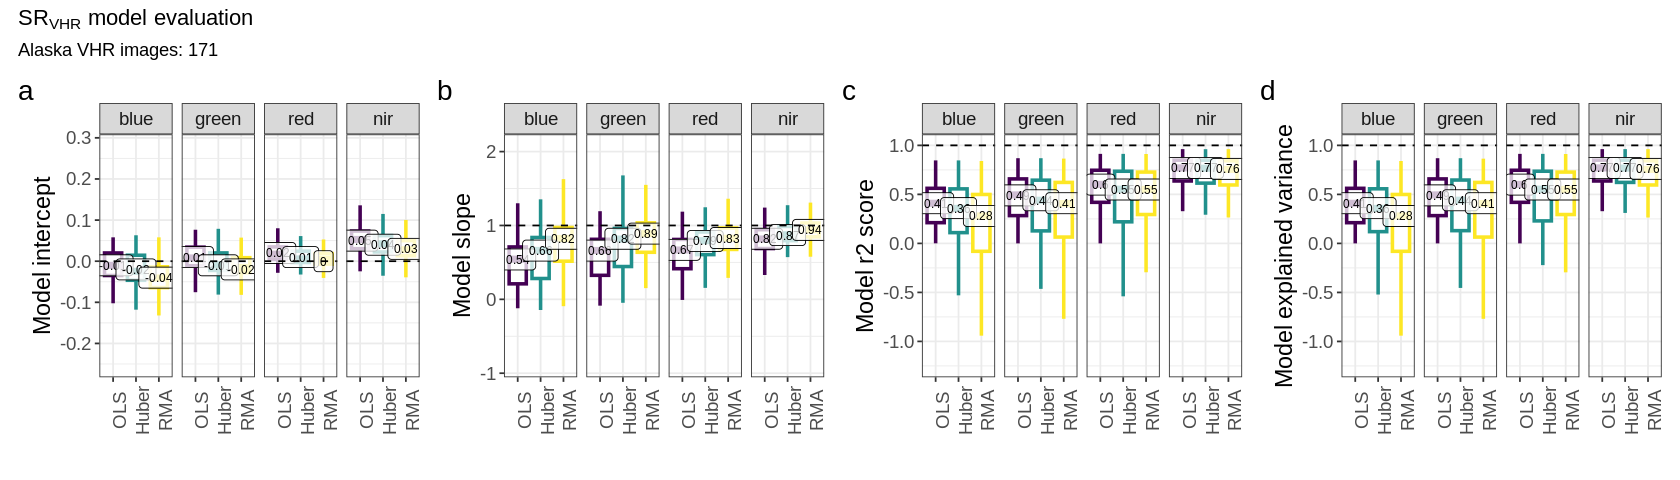

In [82]:
options(repr.plot.width = 14, repr.plot.height = 4)

make_model_stats_boxplots <- function(df_tmp, y, y_name, y_intercept){
    box_p = df_tmp %>%
        ggplot() +
        geom_boxplot(aes(y= {{ y }} , x=comparison, color=comparison), size=1, show.legend=FALSE, outlier.shape = NA) +
        geom_label(data=smry, aes(y={{ y }}, x=comparison, label={{ y }}), size=2.5, alpha=0.75) + 
        geom_hline(aes(yintercept=y_intercept), linetype='dashed')+
        geom_list +
        facet_grid(. ~ band ,
                           # labeller = labeller(comparison = as_labeller(model_type_labels),
                           #                               band = as_labeller(band_name_labels))
                          ) +
        theme(axis.text.x = element_text(angle=90)) +
        labs(y=y_name, x='', caption=NULL)
    }

layout = "
ABCD
"
NUM_VHR = length(levels(factor(df_tmp$catid)))

make_model_stats_boxplots(df_tmp, intercept, 'Model intercept', y_intercept=0) + #box_slope + box_r2 +
make_model_stats_boxplots(df_tmp, slope, 'Model slope', y_intercept=1) +
make_model_stats_boxplots(df_tmp, r2_score, 'Model r2 score', y_intercept=1) +
make_model_stats_boxplots(df_tmp, explained_variance, 'Model explained variance', y_intercept=1) +
    plot_layout(design = layout, guides = "collect") +
    plot_annotation(tag_levels = 'a', title=expression(SR[VHR]~model~evaluation), paste0(REGION, ' VHR images: ', NUM_VHR ) ) 

In [83]:
fight=2.5
figwd=5
figdpi=400

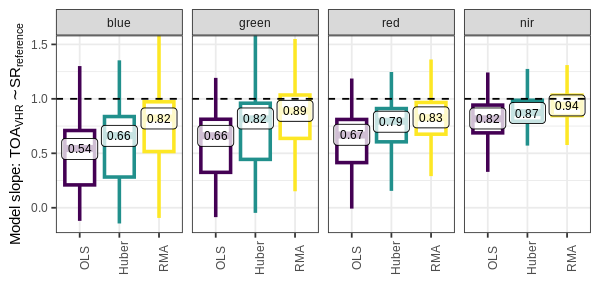

In [84]:
options(repr.plot.height = fight, repr.plot.width = figwd)
p_boxplots_slope_modelchoice = make_model_stats_boxplots(df_tmp, slope, 
                                                         #'Model slope'
                                                         expression(paste("Model slope:"~TOA[VHR]%~%SR[reference])), 
                                                         y_intercept=1) + 
    #labs(caption = paste0('SR-lite model evaluation: ', REGION )) + 
    coord_cartesian(ylim = c(-0.15,1.5)) +
    theme(text = element_text(size=9))

p_boxplots_slope_modelchoice

In [17]:
DATA_NAME_STEM = "plot_modelchoice_slope_alaska"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'tiff')){
    fig_fn = path(DIR_SRLITE_OUTPLOTS, paste0("figure_",DATA_NAME_STEM,"_", EXPORT_TIME_STR,".", OUT_TYPE))
    print(fig_fn)
    ggsave(plot = p_boxplots_slope_modelchoice,
           file = fig_fn,
           device = OUT_TYPE, height = fight, width = figwd, dpi = figdpi)
}

/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss/plots/figure_plot_modelchoice_slope_alaska__20240415.png
/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss/plots/figure_plot_modelchoice_slope_alaska__20240415.tiff


Using region, band, comparison as id variables

Warning message:
“Removed 2052 rows containing non-finite values (`stat_boxplot()`).”


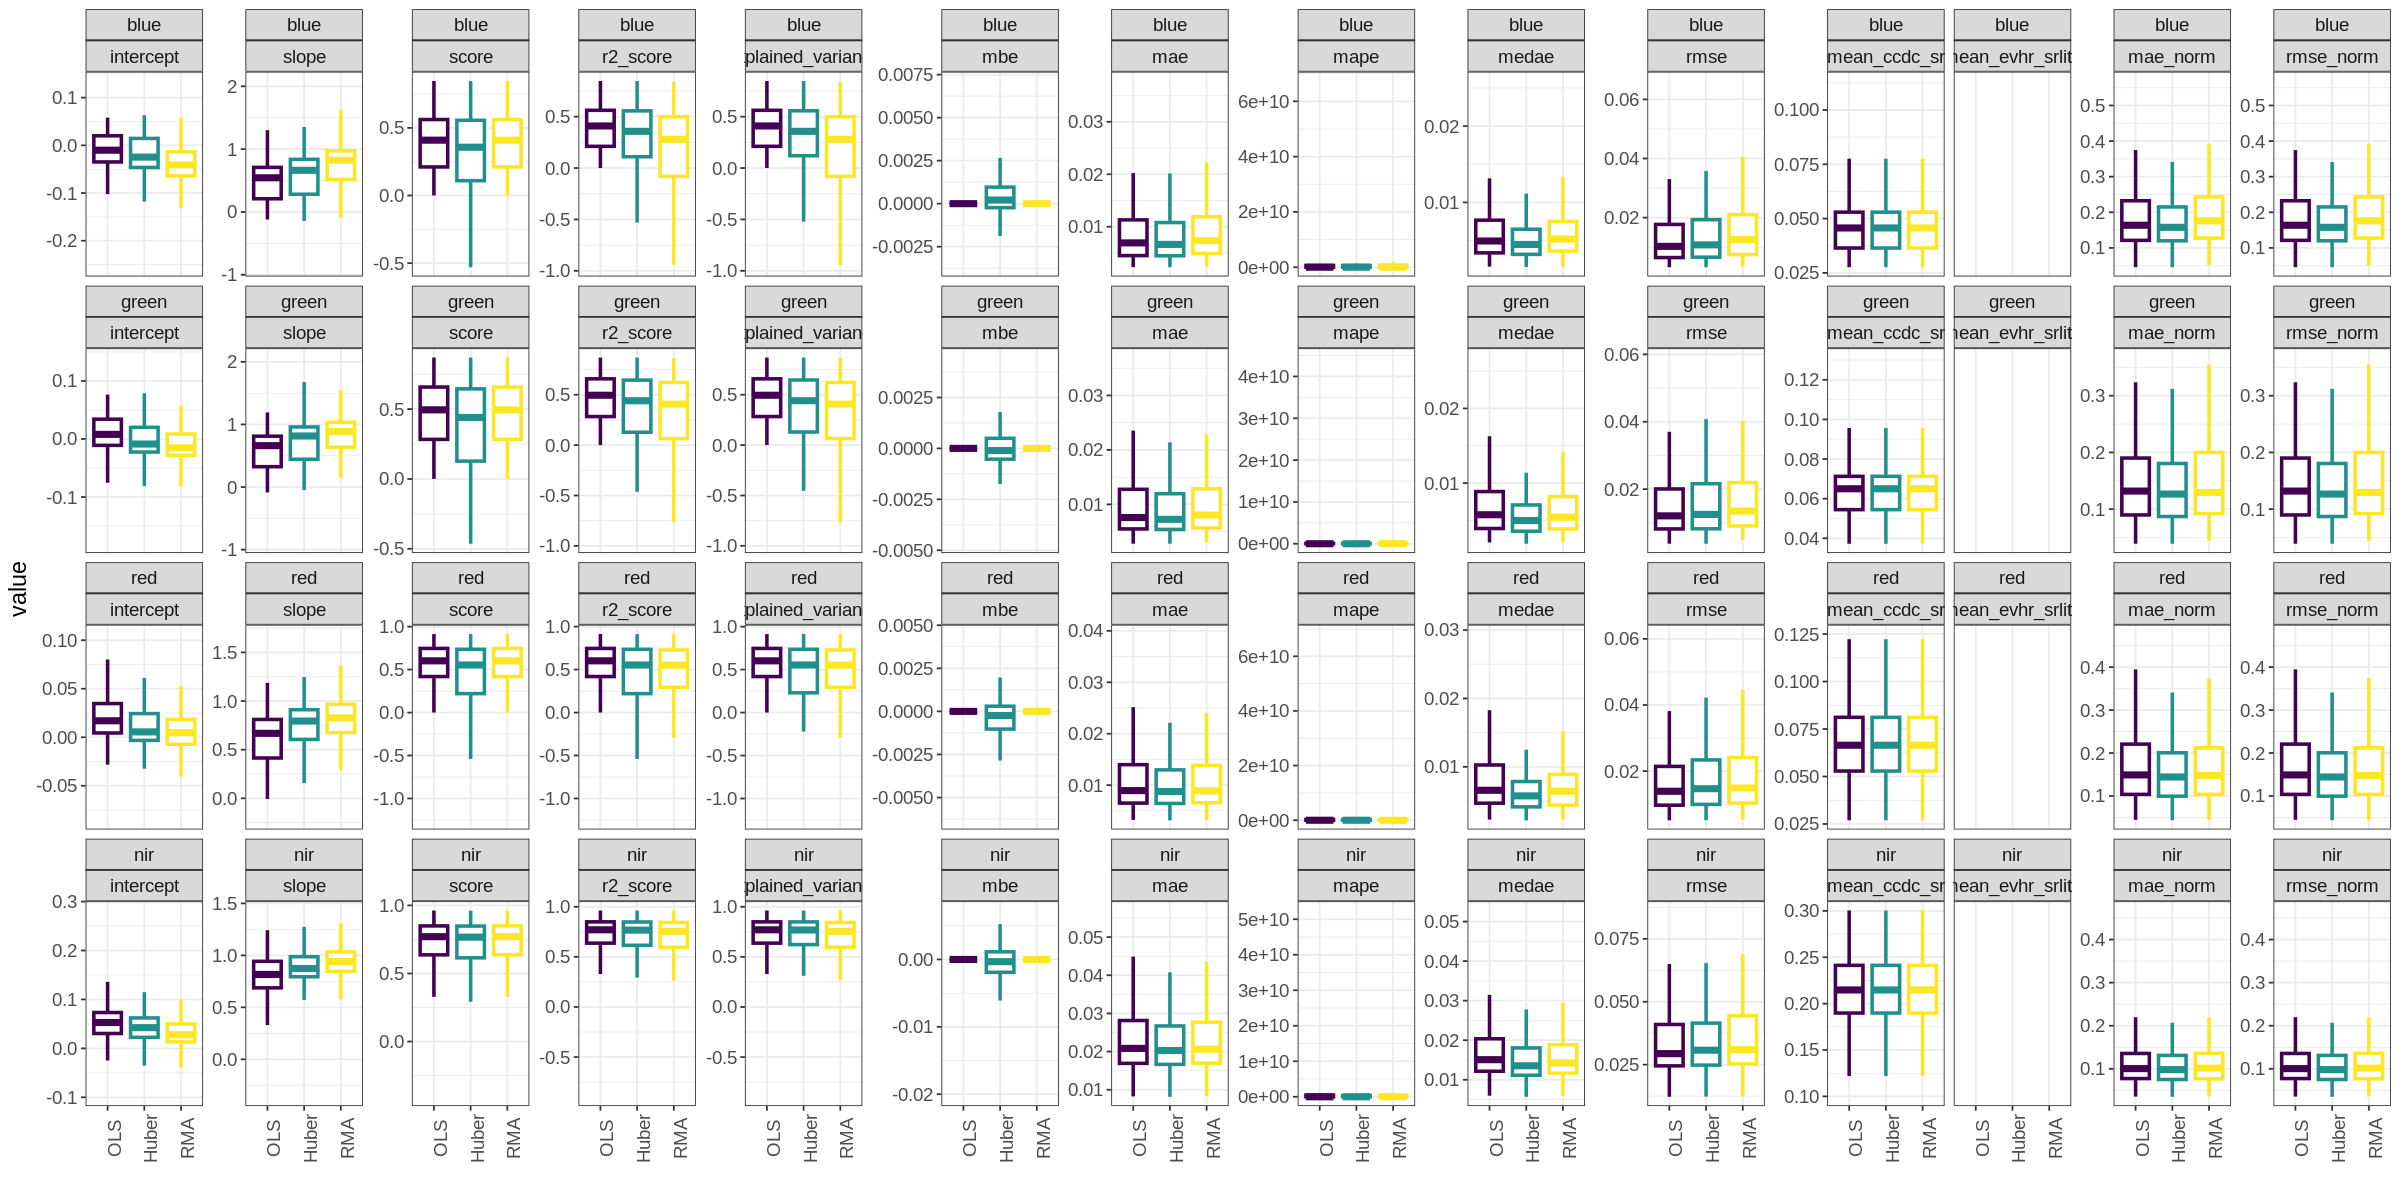

In [85]:
options(repr.plot.width = 20, repr.plot.height = 10)

library(reshape2)

stats_cols_list = c('intercept','slope','score','r2_score','explained_variance','mbe','mae','mape','medae','rmse','mean_ccdc_sr','mean_evhr_srlite','mae_norm','rmse_norm','comparison')
df_tmp.m = melt(df_tmp %>% dplyr::select(region,  band, all_of(stats_cols_list)), id_vars = c('region',  'band'))

df_tmp.m %>% 
        ggplot() +
        geom_boxplot(aes(y= value , x=comparison, color=comparison), size=1, show.legend=FALSE, outlier.shape = NA) +
        #geom_hline(aes(yintercept=y_intercept), linetype='dashed')+
        geom_list +
        facet_wrap(band~variable , scales="free_y", ncol=length(stats_cols_list)-1
                           # labeller = labeller(comparison = as_labeller(model_type_labels),
                           #                               band = as_labeller(band_name_labels))
                          ) +
        #scale_y_continuous(limits=c(quantile(df_tmp.m$value, na.rm=TRUE)[2] - 1.5*IQR(df_tmp.m$value, na.rm=TRUE), quantile(df_tmp.m$value, na.rm=TRUE)[4] + 1.5*IQR(df_tmp.m$value, na.rm=TRUE) )) +
        theme(axis.text.x = element_text(angle=90)) +
        labs(x='', caption=NULL)

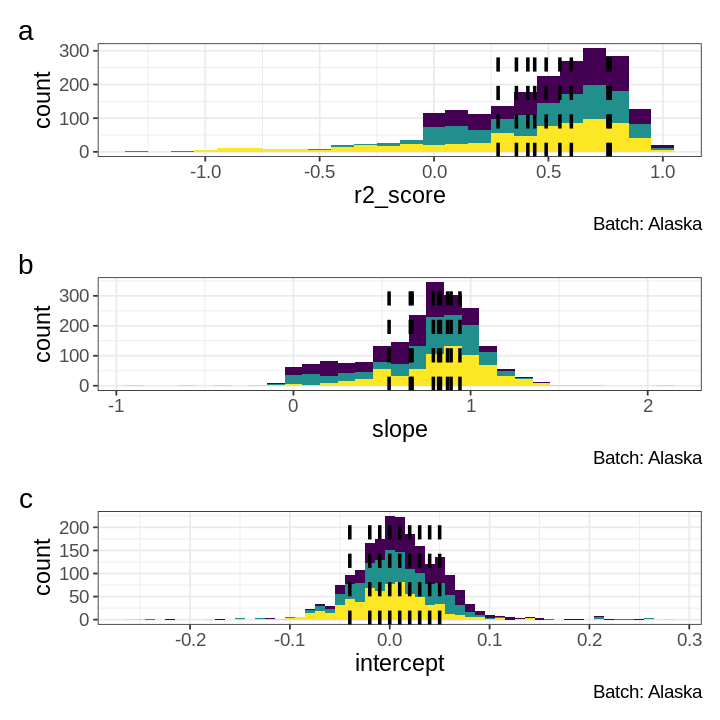

In [86]:
options(repr.plot.width = 6, repr.plot.height = 6)

layout = "
A
B
C
"

hist_r2_score + hist_slope + hist_int +
    plot_layout(design = layout, guides = "collect") +
    plot_annotation(tag_levels = 'a') #+ theme(plot.tag = element_text(size = 26))

# Read in global SAMPLE of pixels (0.1%) of each image

### Sample of reflectance from 30m pixels from the stack of SRLite output, TOA input, and CCDC input (with common mask applied)
From all batches, a sample of 0.001 of the pixels is used to compare results across all images, bands, and linear models

In [87]:
sample_reflectance_table_fn = path(DIR_SRLITE, '/srlite_diagnostics_20221028/global/global_from_sample_p001.csv')

In [88]:
reflect_df <- read_csv(sample_reflectance_table_fn) %>%
    separate(file_name, sep='csv/', into=c('dir', 'region'), remove=FALSE) %>%
    separate(region, sep='_', into=c('region', 'sensor','date','type','catid'), remove=TRUE)

#%>%
#   select(file_name, everything(), -`...1`) %>%
#   rename(path = file_name) %>%
#   mutate(file = path_file(path),
#          region = str_split_fixed(file, '_', 6)[,1],
#          satellite = str_split_fixed(file, '_', 6)[,2],
#          yyyymmdd = str_split_fixed(file, '_', 6)[,3],
#          prod_code = str_split_fixed(file, '_', 6)[,4],
#          catid = str_split_fixed(file, '_', 6)[,5])

reflectances <- tibble(ReflectanceType = c('CCDC_SR','EVHR_TOA','EVHR_SRLite','EVHR_OTF_RMA','EVHR_OTF_OLS','EVHR_OTF_Huber'))
                       # ReflectanceTypePretty = c('CCDC SR', 'EVHR TOAR', 'EVHR SRLite', 'EVHR OTF RMA SR', 'EVHR OTF OLS SR', 'EVHR OTF Huber'))



New names:
• `` -> `...1`
Rows: 414163 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): file_name
dbl (25): ...1, CCDC_SRBlue, CCDC_SRGreen, CCDC_SRRed, CCDC_SRNIR, EVHR_TOAB...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 5 pieces. Additional pieces discarded in 414163 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [102]:
band_names_orig = c('Blue','Green','Red','NIR')

bands <- tibble(Band = band_names_orig,
                Band_so = c(1,2,3,4)) %>%
                  mutate(Band = fct_reorder(Band, Band_so)) %>%
                  select(-Band_so)

In [103]:
reflectances_bands <- crossing(reflectances, bands) %>%
  mutate(name = glue('{ReflectanceType}{Band}'))

reflect_df_longer <- reflect_df %>%
  pivot_longer(cols=where(is.numeric), values_to='Reflectance') %>%
  left_join(reflectances_bands) %>%
  select(-name)

Joining with `by = join_by(name)`


In [104]:
#levels(factor(reflect_df_longer$Reflectance))
str(reflect_df_longer)

tibble [10,354,075 × 10] (S3: tbl_df/tbl/data.frame)
 $ file_name      : chr [1:10354075] "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100"| __truncated__ "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100"| __truncated__ "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100"| __truncated__ "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100"| __truncated__ ...
 $ dir            : chr [1:10354075] "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/" "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/" "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/" "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/" ...
 $ region         : chr [1:10354075] "Whitesands" "Whitesands

In [105]:
reflect_df_long <- reflect_df_longer %>% drop_na() %>%
  dplyr::group_by(catid, ReflectanceType) %>%
  dplyr::mutate(row = row_number()) %>%
  pivot_wider(names_from=ReflectanceType, values_from=Reflectance) %>%
  dplyr::select(-row) %>%
  dplyr::ungroup()

In [106]:
str(reflect_df_long)

tibble [1,656,652 × 14] (S3: tbl_df/tbl/data.frame)
 $ file_name     : chr [1:1656652] "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100"| __truncated__ "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100"| __truncated__ "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100"| __truncated__ "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100"| __truncated__ ...
 $ dir           : chr [1:1656652] "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/" "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/" "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/" "/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/" ...
 $ region        : chr [1:1656652] "Whitesands" "Whitesands" "Whit

In [107]:
smry_num_images = reflect_df %>%
    dplyr::filter(region == 'Alaska') %>% 
    dplyr::group_by(catid, sensor) %>% 
    dplyr::summarize(n_bands = n()) %>% 
    dplyr::group_by(sensor) %>% 
    dplyr::summarize(n_catid = n())
smry_num_images
sum(smry_num_images$n_catid)

`summarise()` has grouped output by 'catid'. You can override using the
`.groups` argument.


sensor,n_catid
<chr>,<int>
GE01,24
QB02,4
WV02,121
WV03,21


[1] 170

In [108]:
# Get unique list of final catids for analysis
catid_list = levels( factor(reflect_df$catid ))

In [109]:
reflectance_scatter <- function(data, x, y, binWidth, reflMin, reflMax, title) { #xlab, ylab, title) {
    # print(x)
    xname = select(data, {{ x }}) %>% colnames()
    yname = select(data, {{ y }}) %>% colnames()
    
    # Get summary dataframe
    df_eq <- ddply(data[,c(yname, xname, 'region', 'Band')],.(region, Band),c("lm_eqn") )
  
    ggplot(data %>% drop_na(), aes(x={{ x }}, y={{ y }})) +
      # ggplot(data, aes(x=CCDC_SR, y=EVHR_SRLite)) +
        # coord_fixed() +
        coord_cartesian(xlim=c(reflMin,reflMax), ylim=c(reflMin,reflMax)) +
        geom_bin2d(binwidth=binWidth, color=NA) + # Geometric object to use for drawing
        # scale_fill_cmap(trans='log10', name='Count') +
        scale_fill_viridis(trans='log10', name='Count') +
        scale_color_viridis(trans='log10', name='Count') +
        geom_abline(slope = 1, intercept = 0, size=0.5)+
        geom_smooth(method = 'lm', color='red', size=0.5, se=F) +
    geom_label(data=df_eq, aes(x = 1, y = 1,label=paste("R^2: ", r2,sep='')), parse = TRUE, hjust="inward", vjust="inward", size=6, color = "black", fill="white", label.size = NA, label.padding=unit(0.1,"lines"))+
    geom_label(data=df_eq, aes(x = 1, y = 0.85,label=paste("rmse (m):", rmse,sep='')), parse = TRUE, hjust="inward", vjust="inward", size=6, color = "black", fill="white", label.size = NA,label.padding=unit(0.1,"lines"))+
    geom_label(data=df_eq, aes(x = 1, y = 0.7,label=paste("bias (m): ", int,sep='')), parse = TRUE, hjust="inward", vjust="inward", size=6, color = "black", fill="white", label.size = NA, label.padding=unit(0.1,"lines"))+
    geom_label(data=df_eq, aes(x = 1, y = 0.55,label=paste("slope: ", slope,sep='')),parse = TRUE, hjust="inward", vjust="inward", size=6, color = "black", fill="white", label.size = NA, label.padding=unit(0.1,"lines")) +
        facet_wrap('Band', nrow=1) +#, scales='free') +
        #facet_grid(sensor ~ Band) +
        theme_bw() +
        theme(text = element_text(size=20),
              aspect.ratio = 1,
              panel.spacing = unit(0.25, 'inch')) +
                # subplots_adjust={'wspace': 0.25, 'hspace': 0.25}) + # add spacing between facets to make y-axis ticks visible
                # axis.text and strip.text and labs x & y 
        xlab(str_replace(xname, '_', ' ')) +
        ylab(str_replace(yname, '_', ' ')) +
        ggtitle(title) 
    #return(df_eq)
    
}

reflectance_scatter_by_region <- function(data, x, y, binWidth, reflMin, reflMax, region) {
  xname = select(data, {{ x }}) %>% colnames()
  yname = select(data, {{ y }}) %>% colnames()
  df_eq = reflectance_scatter(data %>% filter(region == {{ region }}), {{ x }}, {{ y }}, binWidth, reflMin, reflMax, region)
  #ggsave(path(wDir, '20221028', 'plots', glue('{region}_{yname}_v_{xname}.png')), width=5, height=4, dpi=600)
  #return(df_eq)
}

In [110]:
labs_final_toa_ref =  list(labs(y=expression(TOA[VHR]), x=expression(SR[reference]), title=NULL))
labs_final_sr_ref =   list(labs(y=expression(SR[VHR]), x=expression(SR[reference]), title=NULL))
labs_final_sr_toa =   list(labs(y=expression(SR[VHR]), x=expression(TOA[VHR]), title=NULL))

In [111]:
ID_VARS = c('region','sensor','date','type','catid','Band')
MEASURE_VARS = c('CCDC_SR','EVHR_TOA','EVHR_SRLite')
df = melt(reflect_df_long, id.vars=ID_VARS, measure.vars = MEASURE_VARS)

In [112]:
# ggplot(df %>% drop_na(), aes(x={{ x }}, y={{ y }})) +
#     coord_cartesian(xlim=c(0,1), ylim=c(0,1)) +
#     geom_bin2d(binwidth=0.1, color=NA) + # Geometric object to use for drawing
#     scale_fill_viridis(trans='log10', name='Count') +
#     scale_color_viridis(trans='log10', name='Count') +
#     geom_abline(slope = 1, intercept = 0, size=0.5)+
#     geom_smooth(method = 'lm', color='red', size=0.5, se=F) +
#     #facet_wrap('Band', nrow=1) +#, scales='free') +
#     facet_grid(sensor ~ Band) +
#     theme_bw() +
#     theme(text = element_text(size=20),
#           aspect.ratio = 1,
#           panel.spacing = unit(0.25, 'inch')) +
#             # subplots_adjust={'wspace': 0.25, 'hspace': 0.25}) + # add spacing between facets to make y-axis ticks visible
#             # axis.text and strip.text and labs x & y 
#     xlab(str_replace(xname, '_', ' ')) +
#     ylab(str_replace(yname, '_', ' ')) +
#     ggtitle(title) 

In [113]:
head(reflect_df_long)

file_name,dir,region,sensor,date,type,catid,Band,CCDC_SR,EVHR_TOA,EVHR_SRLite,EVHR_OTF_OLS,EVHR_OTF_Huber,EVHR_OTF_RMA
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,Blue,0.4956,0.4687,0.4287,0.4386399,0.4352849,0.4285375
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,Green,0.5878,0.4893,0.4854,0.4919118,0.4868985,0.4856845
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,Red,0.6604,0.5566,0.5537,0.5631071,0.5560121,0.5542318
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,NIR,0.7143,0.5704,0.5838,0.5980495,0.5900130,0.5844058
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,Blue,0.4829,0.5563,0.5151,0.5033454,0.5002145,0.5155242
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,Green,0.5884,0.6085,0.5963,0.5871009,0.5878987,0.5965483


In [118]:
levels(reflect_df_long$Band) = band_name_ordered_labels
head(reflect_df_long)

file_name,dir,region,sensor,date,type,catid,Band,CCDC_SR,EVHR_TOA,EVHR_SRLite,EVHR_OTF_OLS,EVHR_OTF_Huber,EVHR_OTF_RMA
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,blue,0.4956,0.4687,0.4287,0.4386399,0.4352849,0.4285375
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,green,0.5878,0.4893,0.4854,0.4919118,0.4868985,0.4856845
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,red,0.6604,0.5566,0.5537,0.5631071,0.5560121,0.5542318
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,nir,0.7143,0.5704,0.5838,0.5980495,0.5900130,0.5844058
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,blue,0.4829,0.5563,0.5151,0.5033454,0.5002145,0.5155242
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,green,0.5884,0.6085,0.5963,0.5871009,0.5878987,0.5965483


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


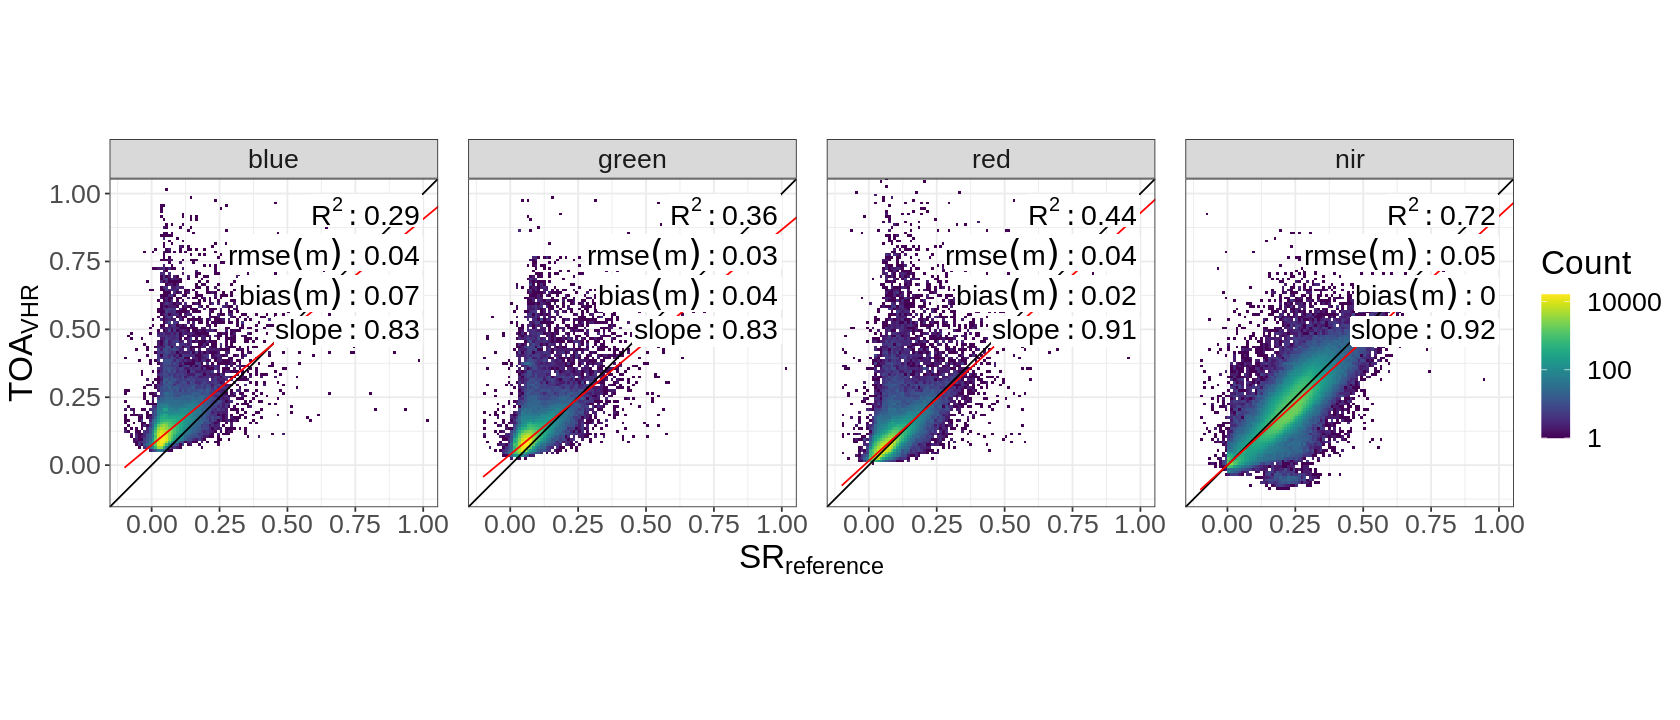

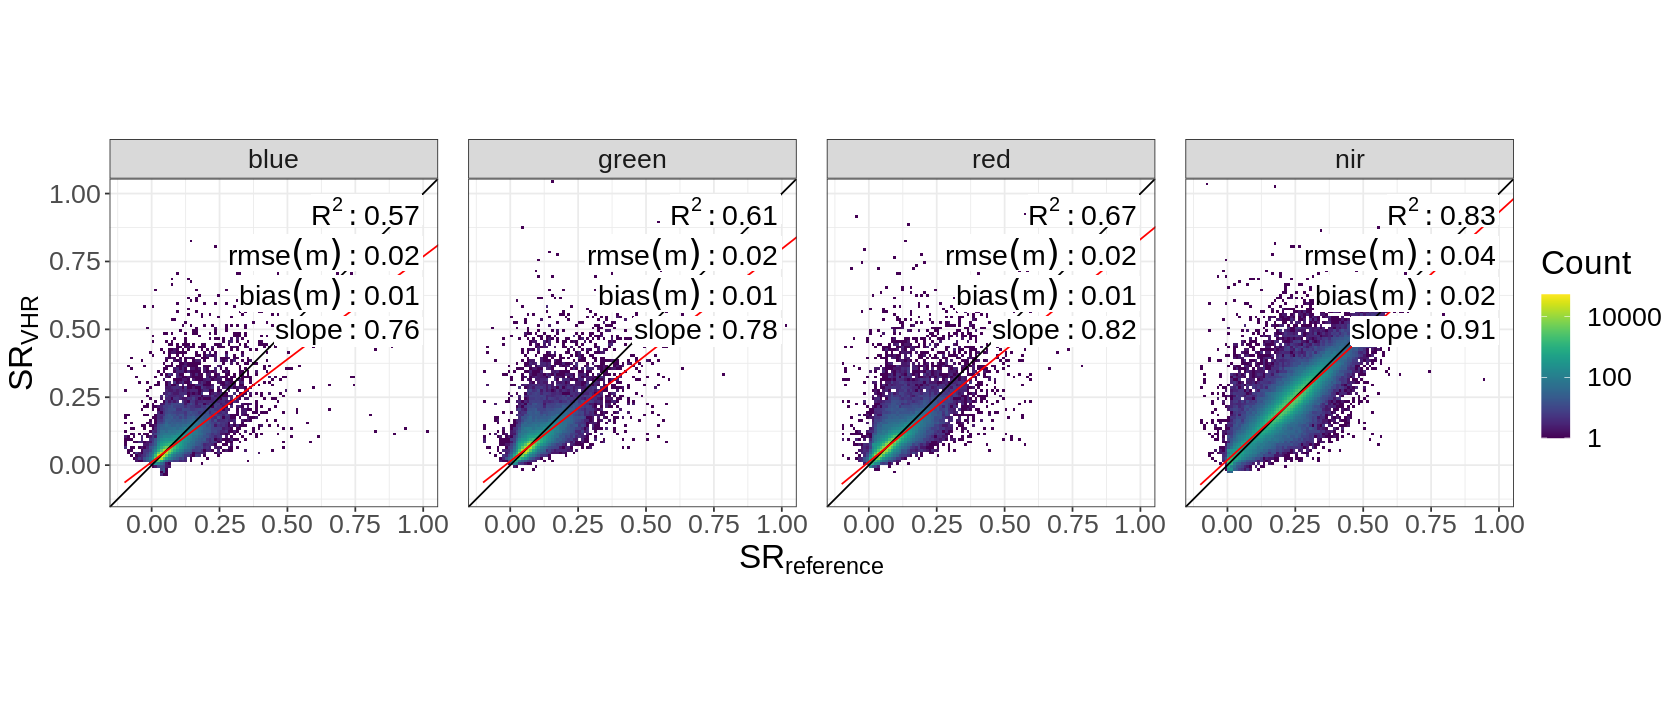

In [119]:
options(repr.plot.width = 14, repr.plot.height = 6)

# reflectance_scatter(reflect_df_long %>% filter(region == 'Whitesands'), CCDC_SR, EVHR_TOA, 0.002, -0.1, 1, 'Whitesands')
p_scatter_toa_ref = reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_TOA, 0.01, -0.1, 1, 'Alaska') + labs_final_toa_ref 
p_scatter_sr_ref = reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_SRLite, 0.01, -0.1, 1, 'Alaska') + labs_final_sr_ref
#reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_SRLite, 0.002, -0.1, 1, 'Alaska')
#reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_SRLite, 1, 'CCDC SR', 'EVHR SRLite', 'title', 'Whitesands')
p_scatter_toa_ref
p_scatter_sr_ref
# cn = select(reflect_df_long, 'CCDC_SR') %>% colnames()
# print(cn)
# cn
# cn[1]
# class(cn)
# reflectance_scatter(reflect_df_long, CCDC_SR, EVHR_TOA, 1, 'CCDC SR', 'EVHR TOA', 'title')

In [120]:
#head(reflect_df_long %>% dplyr::filter( (Band == 'NIR') & (catid %in% catid_list_low_sunel )))

`geom_smooth()` using formula = 'y ~ x'


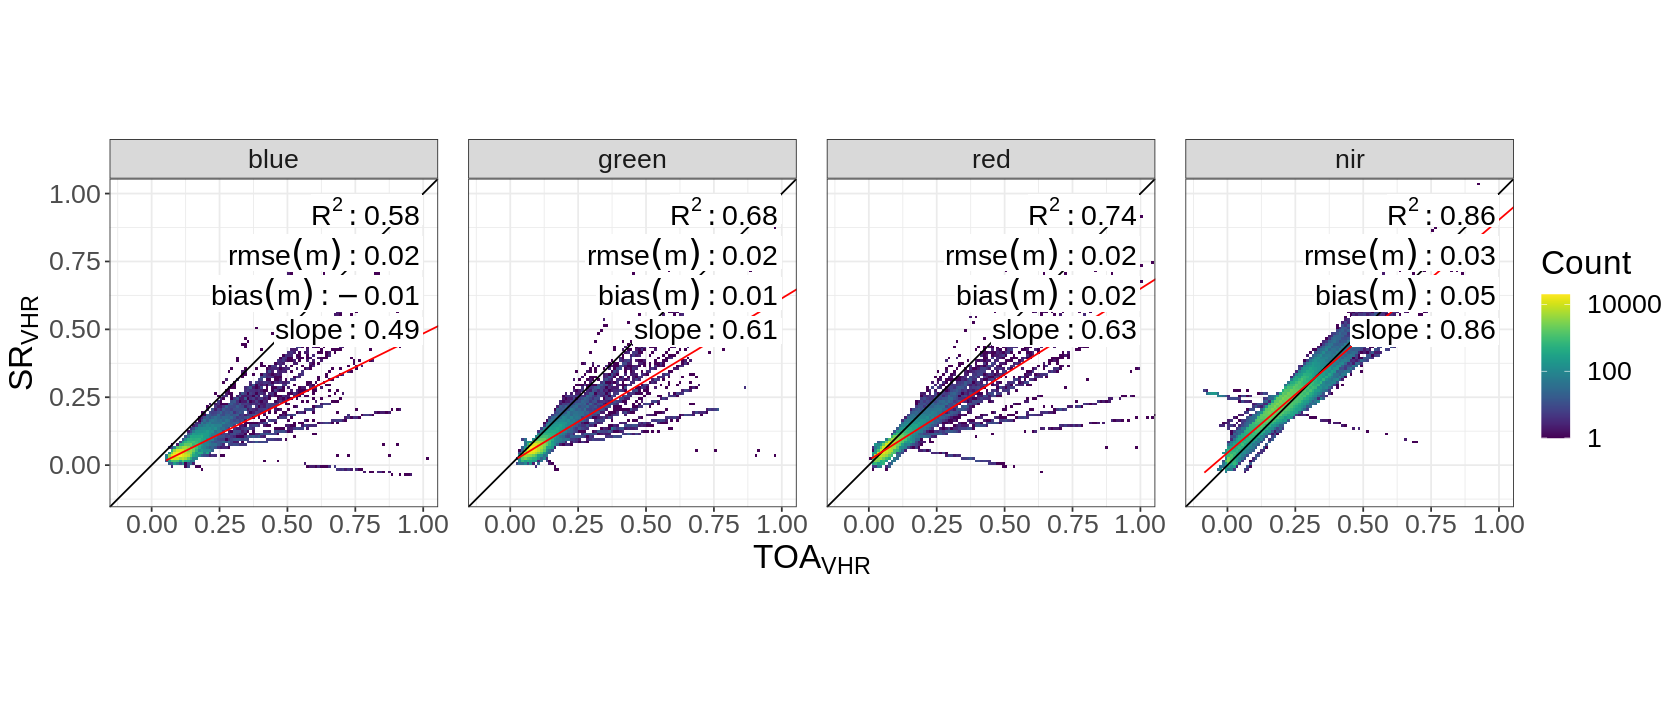

In [121]:
options(repr.plot.width = 14, repr.plot.height = 6)
p_scatter_sr_toa = reflectance_scatter_by_region(reflect_df_long, EVHR_TOA, EVHR_SRLite, 0.01, -0.1, 1, 'Alaska') + labs_final_sr_toa
p_scatter_sr_toa

In [122]:
levels(factor(reflect_df_long$region))

[1] "Alaska"         "Howland"        "Laselva"        "RailroadValley"
[5] "Senegal"        "Siberia"        "Whitesands"

`geom_smooth()` using formula = 'y ~ x'


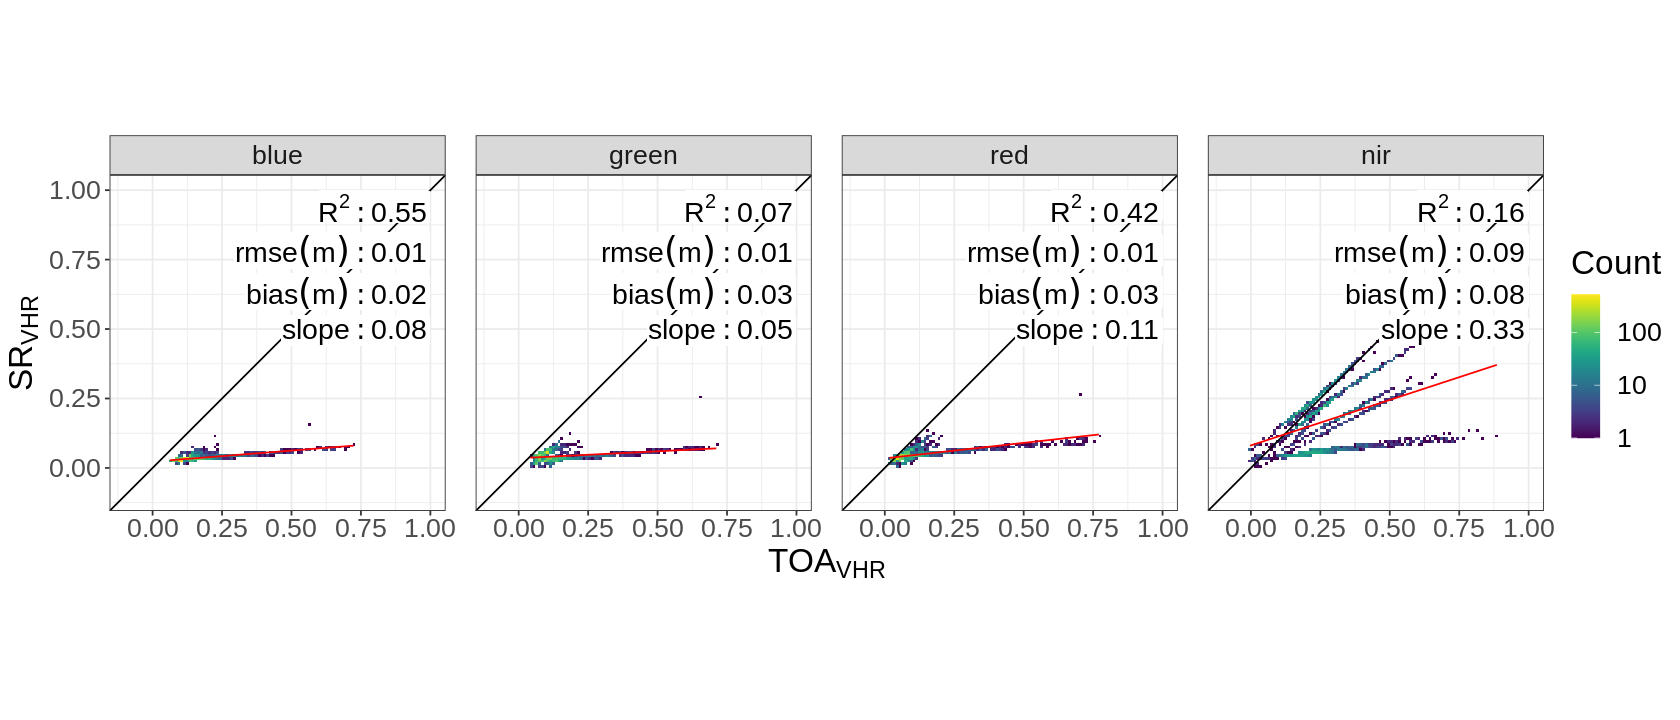

In [123]:
p_scatter_sr_toa_senegal = reflectance_scatter_by_region(reflect_df_long, EVHR_TOA, EVHR_SRLite, 0.01, -0.1, 1, 'Howland') + labs_final_sr_toa
p_scatter_sr_toa_senegal

# Read VHR attributes table
from vhr_xml_dataframe.ipynb  

In [124]:
#vhr_df = read_csv('/explore/nobackup/people/pmontesa/srlite/srlite_alaska_igarss.csv', show_col_types = FALSE)
vhr_df = st_read('/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_srlite_alaska_igarss.gpkg')

# Filter by catid list
vhr_df = vhr_df %>% filter(catid %in% catid_list)

dim(vhr_df)
vhr_df %>% group_by(sensor) %>%
    dplyr::summarize(cnt = n()) %>%
    as.data.frame()
#head(vhr_df %>% filter(sensor == 'GE01' | sensor == 'QB02'))
#head(vhr_df %>% select(id, sunel, sunaz, az, sensor))
#levels(factor(vhr_df$sensor))

Reading layer `footprints_vhrmeta_srlite_alaska_igarss' from data source 
  `/panfs/ccds02/nobackup/people/pmontesa/srlite/footprints_vhrmeta_srlite_alaska_igarss.gpkg' 
  using driver `GPKG'
Simple feature collection with 172 features and 18 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -166.089 ymin: 54.94875 xmax: -130.1822 ymax: 71.04099
Geodetic CRS:  WGS 84


[1] 170  19

sensor,cnt,geom
<chr>,<int>,<MULTIPOLYGON [°]>
GE01,24,MULTIPOLYGON (((-141.4698 6...
QB02,4,MULTIPOLYGON (((-154.989 66...
WV02,121,MULTIPOLYGON (((-145.7376 6...
WV03,21,MULTIPOLYGON (((-130.6814 5...


### Map window in equal area projection

`Reference`: https://www.r-bloggers.com/2019/04/zooming-in-on-maps-with-sf-and-ggplot2/

In [1]:
if(FALSE){
    # Window for map crop for wide map
    # Set a crop extent that will be larger than the display extent
    XMIN = -168
    XMAX=-110
    YMIN=45
    YMAX=71

    target_crs = 3338

    worldmap = ne_countries(scale = 10, returnclass = 'sf')
    worldmap_cropped <- st_crop(worldmap, xmin = XMIN, xmax = XMAX, ymin = YMIN, ymax = YMAX)

    disp_win_wgs84 <- st_sfc(st_point(c(XMIN+1, YMIN+10)), st_point(c(XMAX-1, YMAX-5)), crs = 4326)
    disp_win_trans <- st_transform(disp_win_wgs84, crs = target_crs)
    disp_win_coord <- st_coordinates(disp_win_trans)
    
}else{
    
    # Window for map crop for tall map
    # Set a crop extent that will be larger than the display extent
    # XMIN = -168
    # XMAX=-115
    # YMIN=35
    # YMAX=73
    XMIN = -167
    XMAX=-115
    YMIN=30
    YMAX=73

    target_crs = 3338

    worldmap = ne_countries(scale = 10, returnclass = 'sf')
    worldmap_cropped <- st_crop(worldmap, xmin = XMIN, xmax = XMAX, ymin = YMIN, ymax = YMAX)

    disp_win_wgs84 <- st_sfc(st_point(c(XMIN+4, YMIN+10)), st_point(c(XMAX, YMAX-5)), crs = 4326)
    disp_win_trans <- st_transform(disp_win_wgs84, crs = target_crs)
    disp_win_coord <- st_coordinates(disp_win_trans)
    }

ERROR: Error in ne_countries(scale = 10, returnclass = "sf"): could not find function "ne_countries"


In [12]:
options(repr.plot.width = 6, repr.plot.height = 6)

map_vhr = ggplot() + 
    geom_sf(data=worldmap_cropped  ) +
    geom_sf(data=vhr_df , aes(fill=sensor)) + 
    scale_fill_viridis_d(option = 'turbo', name='Sensor') +
    theme_bw() +
    theme(text = element_text(size=16), legend.position = c(0.9, 0.85) )+
    theme(legend.background = element_rect(colour = 'black', fill = 'white', linetype='solid')) +
    #coord_sf(crs = st_crs(3338), xlim = c(-170, -128), ylim = c(54, 72), expand = FALSE)
    coord_sf(xlim = disp_win_coord[,'X'], ylim = disp_win_coord[,'Y'], crs = target_crs, expand = FALSE) #+
    #coord_sf(crs = st_crs(target_crs), expand = FALSE)

map_vhr

ERROR: Error in ggplot(): could not find function "ggplot"


In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)

worldmap = ne_countries(scale = 10, returnclass = 'sf')

map_vhr = ggplot() + 
    geom_sf(data=worldmap_cropped) +
    geom_sf(data=vhr_df, alpha=1, size=0, fill='black') + 
    geom_label(aes(x=Inf, y=-Inf, label=paste("n [VHR] == ", dim(vhr_df)[1])), hjust='inward', vjust='inward', parse=TRUE, size=8, label.size = NA) +
    labs(y=NULL, x=NULL) +
    theme_bw() +
    theme(text = element_text(size=16), legend.position = c(0.9, 0.85) )+
    #coord_sf(xlim = c(XMIN, -135), ylim = c(YMIN, YMAX), expand = FALSE)
coord_sf(xlim = disp_win_coord[,'X'], ylim = disp_win_coord[,'Y'], crs = target_crs, expand = FALSE)


map_vhr

ERROR: Error in ne_countries(scale = 10, returnclass = "sf"): could not find function "ne_countries"


### Read in polar plot done in python
`code/geoscitools/vhr_xml_dataframe.ipynb`

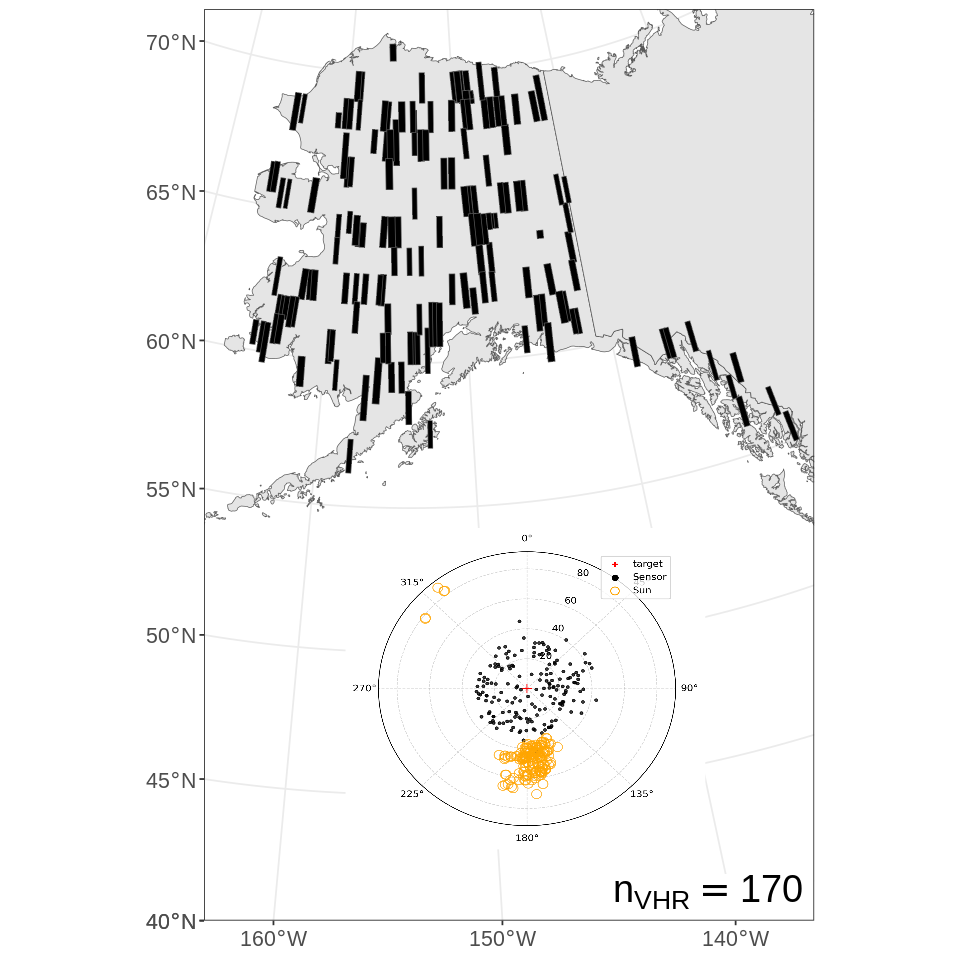

In [44]:
options(repr.plot.width = 8, repr.plot.height = 8)

polar_plot_img <- readPNG(path(DIR_SRLITE_OUTPLOTS, 'igarss_srlite_alaska_polarplot.png'), native=FALSE)

if(FALSE){
    # Window for image placement on wide map
    MAP_HEIGHT = 8
    MAP_WIDTH = 12
    # Coords for placement of image
    XMIN = -150+10
    XMAX=-115
    YMIN=50+2
    YMAX=70

    img_win_wgs84 <- st_sfc(st_point(c(XMIN+0, YMIN+9)), st_point(c(XMAX+3, YMAX-4.25)), crs = 4326)
    img_win_trans <- st_transform(img_win_wgs84, crs = target_crs)
    img_win_coord <- st_coordinates(img_win_trans)
}else{
    # Window for image placement on tall map
    MAP_HEIGHT = 12
    MAP_WIDTH = 8
    
    # Coords for placement of image
    XMIN = -157
    XMAX=-137
    YMIN=43
    YMAX=53

    img_win_wgs84 <- st_sfc(st_point(c(XMIN, YMIN)), st_point(c(XMAX, YMAX)), crs = 4326)
    img_win_trans <- st_transform(img_win_wgs84, crs = target_crs)
    img_win_coord <- st_coordinates(img_win_trans)
    }

map_vhr_polar_plot_img <- map_vhr +
    #background_image(polar_plot_img) 
    annotation_raster(polar_plot_img, xmin = img_win_coord[,'X'][1], xmax = img_win_coord[,'X'][2], 
                      ymin = img_win_coord[,'Y'][1], ymax = img_win_coord[,'Y'][2], interpolate=TRUE) 
map_vhr_polar_plot_img

In [45]:
DATA_NAME_STEM = "map_results_alaska"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    fig_fn = path(DIR_SRLITE_OUTPLOTS, paste0("figure_",DATA_NAME_STEM,"_", EXPORT_TIME_STR,".", OUT_TYPE))
    print(fig_fn)
    ggsave(plot = map_vhr_polar_plot_img,
           file = fig_fn,
           device = OUT_TYPE, dpi = 300, height = MAP_HEIGHT, width = MAP_WIDTH)
}

/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss/plots/figure_map_results_alaska__20240415.png
/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss/plots/figure_map_results_alaska__20240415.pdf


#### Read in an image and place it on the plot  
image of polar plot from python code  
https://www.littlemissdata.com/blog/patchwork

In [46]:
head(reflect_df_long)

file_name,dir,region,sensor,date,type,catid,Band,CCDC_SR,EVHR_TOA,EVHR_SRLite,EVHR_OTF_OLS,EVHR_OTF_Huber,EVHR_OTF_RMA
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,blue,0.4956,0.4687,0.4287,0.4386399,0.4352849,0.4285375
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,green,0.5878,0.4893,0.4854,0.4919118,0.4868985,0.4856845
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,red,0.6604,0.5566,0.5537,0.5631071,0.5560121,0.5542318
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,nir,0.7143,0.5704,0.5838,0.5980495,0.5900130,0.5844058
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,blue,0.4829,0.5563,0.5151,0.5033454,0.5002145,0.5155242
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150501_M1BS_10300100418D7000_sample_p001.csv,/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/,Whitesands,WV02,20150501,M1BS,10300100418D7000,green,0.5884,0.6085,0.5963,0.5871009,0.5878987,0.5965483


# Slope (SRlite ~ TOA) vs sunel

In [47]:
library(broom)

#X_VAR = select(reflect_df_long, 'EVHR_TOA') %>% colnames()
#X_VAR = 'EVHR_TOA'

# Model expects orig band names
levels(reflect_df_long$Band) = band_names_orig

smry_slope = reflect_df_long %>% 
    dplyr::filter(region == 'Alaska', Band == 'NIR') %>%
    dplyr::nest_by(Band, catid, sensor) %>%
    dplyr::mutate(mod = list(lm(EVHR_SRLite ~ EVHR_TOA, data = data))) %>% 
    dplyr::summarize(tidy(mod)) %>% filter(term != '(Intercept)') %>% 
    dplyr::left_join(vhr_df %>% select(catid, sunel, sunaz, el, az), by = c('catid' = 'catid'))
    #summarize(glance(mod))
    #summarize(augment(mod))
    N_catids = dim(smry_slope)[1]
    print(paste0('model slopes from samples of NIR band relationships for ', N_catids, ' images'))

catid_list_low_sunel = (smry_slope %>% filter(sunel<15))$catid

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”`summarise()` has grouped output by 'Band', 'catid', 'sensor'. You can override
using the `.groups` argument.

[1] "model slopes from samples of NIR band relationships for 170 images"


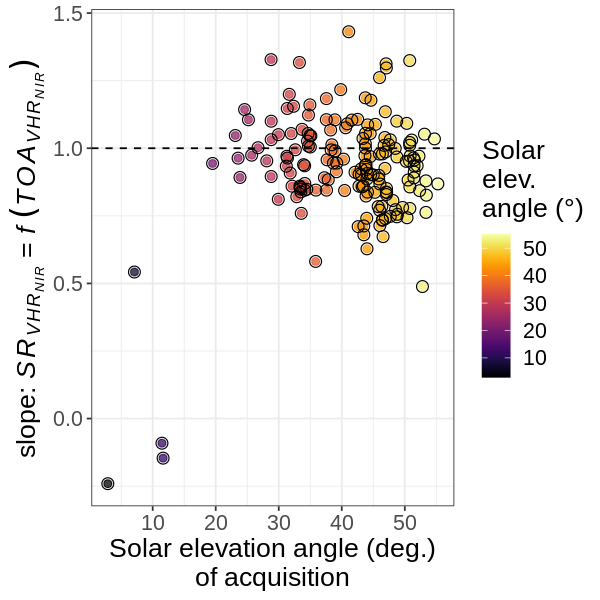

In [48]:
options(repr.plot.width = 5, repr.plot.height = 5)

p_smry_slope = smry_slope %>%
    ggplot(aes(x = sunel, y = estimate)) +
        geom_point(aes(color = sunel), shape = 20,  size = 3, alpha=.75) +
        scale_color_viridis(name = 'Solar\nelev.\nangle (°)', option='inferno') +
        geom_point(aes(color = sunaz), shape = 21, color='black', size = 3) +
        geom_hline(yintercept=1, linetype='dashed') +
        #facet_grid(satellite ~ Band) +
        #facet_wrap(~satellite, ncol=4) +
        labs(
            y = expression(paste('slope:'~italic(SR[VHR[NIR]])~'='~italic(f~(TOA[VHR[NIR]])))), 
            #y = expression(paste('Model slope\n ', SR[VHR]~'~'~TOA[VHR])),
            x = 'Solar elevation angle (deg.)\nof acquisition', 
             #caption= paste0('model slopes from samples of NIR band relationships for ', N_catids, ' images')
            ) +
    theme_bw() +
    theme(text = element_text(size=16),
          panel.spacing = unit(0.25, 'inch'))

p_smry_slope

`geom_smooth()` using formula = 'y ~ x'`geom_smooth()` using formula = 'y ~ x'`geom_smooth()` using formula = 'y ~ x'

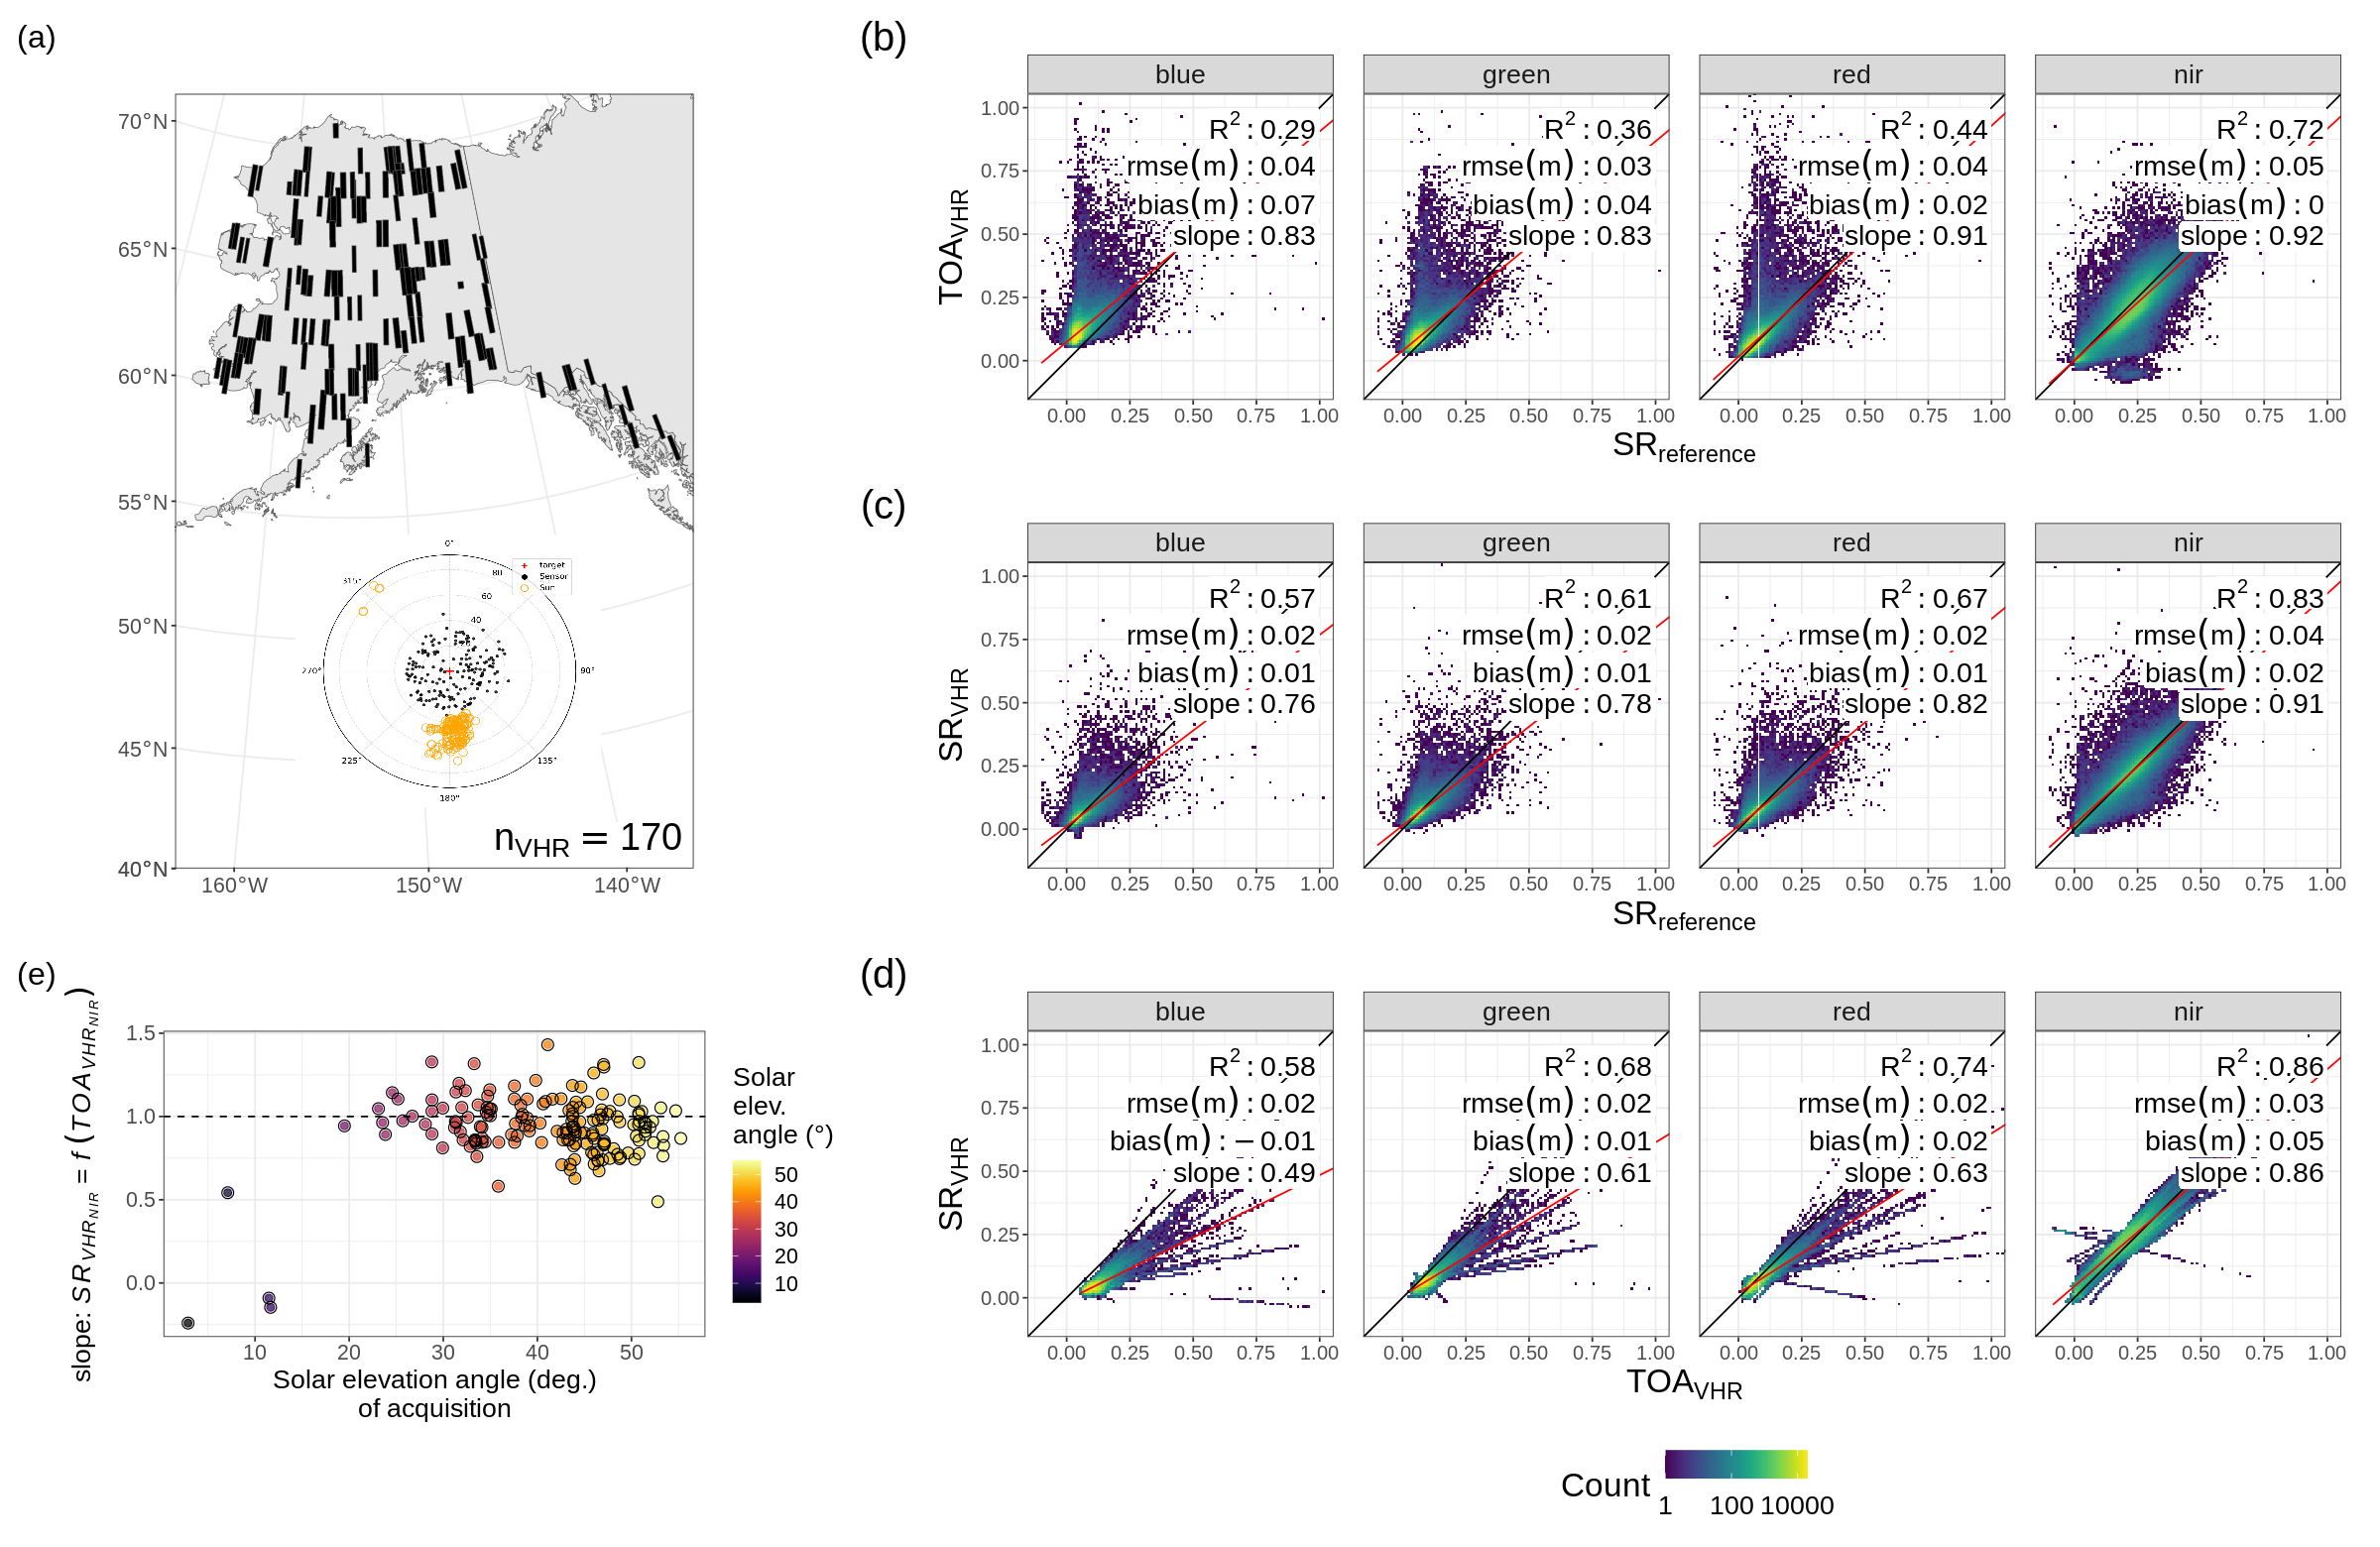

In [49]:
options(repr.plot.width = 20, repr.plot.height = 13)

layout = "
AABBBBB
AACCCCC
EEDDDDD
"
figure = map_vhr_polar_plot_img + 
     (p_scatter_toa_ref + theme(legend.position = "none", axis.text=element_text(size=12))) +
     (p_scatter_sr_ref  + theme(legend.position = "none", axis.text=element_text(size=12))) +
     (p_scatter_sr_toa  + theme(legend.position = "bottom", axis.text=element_text(size=12))) +
    p_smry_slope +
    plot_layout(design = layout) +
    plot_annotation(tag_levels = 'a',tag_prefix = '(', tag_sep = '', tag_suffix = ') ') 


figure


In [50]:
DATA_NAME_STEM = "performance_results_alaska"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'tiff')){
    fig_fn = path(DIR_SRLITE_OUTPLOTS, paste0("figure_",DATA_NAME_STEM,"_", EXPORT_TIME_STR,".", OUT_TYPE))
    print(fig_fn)
    ggsave(plot = figure,
           file = fig_fn,
           device = OUT_TYPE, dpi = 400, height = 12, width = 20)
}

/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss/plots/figure_performance_results_alaska__20240415.png


`geom_smooth()` using formula = 'y ~ x'`geom_smooth()` using formula = 'y ~ x'`geom_smooth()` using formula = 'y ~ x'

/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss/plots/figure_performance_results_alaska__20240415.tiff


`geom_smooth()` using formula = 'y ~ x'`geom_smooth()` using formula = 'y ~ x'`geom_smooth()` using formula = 'y ~ x'